In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# Loading the dataset
#data1 = pd.read_csv('MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv')
data2 = pd.read_csv('MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv')
data3 = pd.read_csv('MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv')
data4 = pd.read_csv('MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
data5 = pd.read_csv('MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
#data6 = pd.read_csv('MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv')
data7 = pd.read_csv('MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
data8 = pd.read_csv('MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [4]:
data_list = [data2, data3, data4, data5, data7, data8]

print('Data dimensions: ')
for i, data in enumerate(data_list, start = 1):
  rows, cols = data.shape
  print(f'Data{i} -> {rows} rows, {cols} columns')

Data dimensions: 
Data1 -> 445909 rows, 79 columns
Data2 -> 692703 rows, 79 columns
Data3 -> 170366 rows, 79 columns
Data4 -> 288602 rows, 79 columns
Data5 -> 286467 rows, 79 columns
Data6 -> 225745 rows, 79 columns


In [5]:
df = pd.concat(data_list)
rows, cols = df.shape

print('New dimension:')
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

New dimension:
Number of rows: 2109792
Number of columns: 79
Total cells: 166673568


In [6]:
# Deleting dataframes after concating to save memory
for d in data_list: del d

In [7]:
# Renaming the columns by removing leading/trailing whitespace
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

In [8]:
print(df.columns)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [9]:
# Separate features from labels
X = df.drop(columns=['Label'])
y = df['Label']

In [10]:
num_splits = 100
split_size = len(df) // num_splits

dfs = []
start = 0
for i in range(num_splits):
    end = start + split_size
    df_slice = df.iloc[start:end].copy()  # copy the slice to avoid reindexing issues

    # Replace infinities in the slice
    df_slice.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop or fill NaNs
    df_slice.dropna(inplace=True)

    dfs.append(df_slice)
    start = end

# Last slice for any leftover rows
if end < len(df):
    df_slice = df.iloc[end:].copy()
    df_slice.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_slice.dropna(inplace=True)
    dfs.append(df_slice)

df = pd.concat(dfs, ignore_index=True)
print("DataFrame shape after cleaning:", df.shape)


DataFrame shape after cleaning: (2107484, 79)


In [11]:
# Replace +∞, -∞ with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows that have become NaN
df.dropna(inplace=True)

# Now separate X and y again
X = df.drop(columns=['Label'])
y = df['Label']

# Then you can do your scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
# 70% train, 15% val, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.15, 
    stratify=y, 
    random_state=42
)

# Now split train_val into train and validation
val_ratio = 0.15 / 0.85  # roughly 0.1765
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_ratio, 
    stratify=y_train_val, 
    random_state=42
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1475238, 78) (1475238,)
Validation set shape: (316123, 78) (316123,)
Test set shape: (316123, 78) (316123,)


Justification for 70-15-15 split:

70% Training: Enough data to learn robust patterns.

15% Validation: A separate set for hyperparameter tuning (e.g., learning rate, noise multiplier for DP, etc.).

15% Test: Kept strictly for final evaluation. This prevents overfitting to the validation set and provides an unbiased measure of performance.

In [13]:
#%pip install tensorflow-privacy

In [14]:
#%pip install tensorflow

In [18]:
# Ensure compatible versions of TensorFlow and TensorFlow Privacy
%pip install tensorflow==2.4.1 tensorflow-privacy==0.5.0

import tensorflow as tf
import tensorflow_privacy

print("TensorFlow version:", tf.__version__)
print("TensorFlow Privacy version:", tensorflow_privacy.__version__)



Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.4.1


ModuleNotFoundError: No module named 'tensorflow_privacy'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

AttributeError: module 'tensorflow.python.util.tf_export' has no attribute 'ESTIMATOR_API_NAME'

In [ ]:
# Hyperparameters
learning_rate   = 0.01
batch_size      = 256
microbatch_size = 64
epochs          = 5
noise_multiplier = 1.1
l2_norm_clip    = 1.0
delta           = 1e-5  # Typical DP delta

def create_model(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # for binary classification
    ])
    return model

model = create_model(X_train.shape[1])

dp_optimizer = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=microbatch_size,
    learning_rate=learning_rate
)

model.compile(
    optimizer=dp_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    verbose=1
)

# Compute approximate epsilon
eps, _ = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
    n=len(X_train),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    epochs=epochs,
    delta=delta
)
print(f"For delta={delta}, the estimated epsilon is: {eps:.2f}")


d:\COPIE\keyssh\INF6422E\INF6422E-TP4\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [ ]:
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, 
    accuracy_score, roc_auc_score
)

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='binary')
rec  = recall_score(y_test, y_pred, average='binary')
f1   = f1_score(y_test, y_pred, average='binary')
auc  = roc_auc_score(y_test, y_prob)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)
print("AUC-ROC:", auc)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


9879/9879 ━━━━━━━━━━━━━━━━━━━━ 5s 536us/step


ValueError: Mix of label input types (string and number)

Interpretation of Confusion Matrix

TP: Attack traffic correctly labeled “attack”.

TN: Benign traffic correctly labeled “benign”.

FP: Benign mislabeled as attack (false alarms).

FN: Attacks mislabeled as benign (missed detections).

Privacy (ε) vs. Accuracy Trade-Off

A higher noise_multiplier → better privacy (lower ε) but generally lower accuracy.

A lower noise_multiplier → weaker privacy (larger ε) but higher accuracy.

Goal: Find a balance that meets your organization’s regulatory/privacy needs while maintaining high detection performance.

In [ ]:
NUM_CLIENTS = 5
client_data = []
total_samples = len(X_train)
samples_per_client = total_samples // NUM_CLIENTS

start = 0
for i in range(NUM_CLIENTS):
    end = start + samples_per_client
    X_c = X_train[start:end]
    y_c = y_train[start:end]
    client_data.append((X_c, y_c))
    start = end

# You might have leftover samples if total_samples is not divisible by NUM_CLIENTS.
# Those leftover samples can go to the last client or be distributed among them.


In [ ]:
#%pip install tensorflow_federated


In [ ]:
import tensorflow_federated as tff
import tensorflow as tf

def create_tf_dataset_for_client(data_tuple):
    X_c, y_c = data_tuple
    ds = tf.data.Dataset.from_tensor_slices((X_c, y_c))
    ds = ds.shuffle(buffer_size=100).batch(32)
    return ds

federated_train_data = [create_tf_dataset_for_client(cd) for cd in client_data]

In [ ]:
def model_fn():
    keras_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(model_fn)
state = iterative_process.initialize()

NUM_ROUNDS = 5
for round_num in range(1, NUM_ROUNDS+1):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f"Round {round_num} metrics: {metrics}")

In [ ]:
from tensorflow_federated.python.aggregators import differential_privacy

dp_factory = differential_privacy.DifferentiallyPrivateFactory.gaussian_fixed(
    noise_multiplier=1.0,
    clients_per_round=NUM_CLIENTS,
    clipped_count_budget=10,  # or as desired
    l2_norm_clip=1.0
)

dp_iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    model_aggregator=dp_factory.create(
        value_type=iterative_process.get_model_weights(state).trainable
    )
)

dp_state = dp_iterative_process.initialize()

for round_num in range(1, NUM_ROUNDS+1):
    dp_state, dp_metrics = dp_iterative_process.next(dp_state, federated_train_data)
    print(f"Round {round_num} DP metrics: {dp_metrics}")

In [ ]:
federated_weights = dp_iterative_process.get_model_weights(dp_state)
model_fed = create_model(X_train.shape[1])  # same architecture as model_fn
federated_weights.assign_weights_to(model_fed)

y_prob_fed = model_fed.predict(X_test).ravel()
y_pred_fed = (y_prob_fed >= 0.5).astype(int)

acc_fed = accuracy_score(y_test, y_pred_fed)
print("Federated model accuracy on test set:", acc_fed)

Comparison with Centralized Model

2.2 Adversarial Analysis and Defense

Model Poisoning: A malicious client uploads gradients that skew or degrade the model.

Defense: Use robust aggregators (e.g., multi-Krum, outlier detection, or differential privacy** with clipping**).

Inference Attacks: Attackers try to infer details about a client’s data from global model parameters.

Defense: User-level differential privacy ensures that updates are clipped and noised, reducing the potential for inference.

Backdoor Attacks: Attackers embed triggers in the model.

Defense: Periodic validation against known safe data, outlier detection in gradient updates, or specialized defensive techniques (e.g., verifiable model updates).

3.1 Feature Importance

To identify the top 5 features contributing to intrusion detection, we can use techniques such as feature importance scores from tree-based models (e.g., Random Forest, XGBoost) or SHAP values. The five most important features in intrusion detection might include:

1. **Source and Destination IP Flow Counts:** Helps detect unusual communication patterns, which are common in DDoS attacks.

2. **Packet Size Distribution:** Abnormal packet sizes may indicate an attempt to exfiltrate data or flood a network.

3. **Connection Duration:** Extremely short or long connections may indicate scanning behavior or persistence techniques.

4. **Request/Response Ratios:** Sudden spikes in request rates could be a sign of brute-force attacks or credential stuffing.

5. **Entropy of Payload Data:** High entropy could suggest encrypted malicious payloads or obfuscated attack traffic.

Each of these features plays a role in detecting different cyberattacks, such as:

* **DDoS attacks:** Abnormally high packet counts and connection requests.

* **Phishing:** Unusual request-response patterns to malicious domains.

* **Data Exfiltration:** Large payload sizes over extended connections.

3.2 Custom Feature Design

To improve intrusion detection, we propose two additional cybersecurity-relevant features:

1. **Behavioral Anomaly Scores:** Using statistical baselines for normal network behavior, an anomaly score can be calculated for each connection. This helps detect zero-day attacks and adaptive threats.

    * **Extraction:** Leverage clustering techniques to define normal behavior and compute deviations.

    * **Impact:** Improves classification accuracy by detecting novel threats.

2. **Temporal Traffic Patterns:** Tracking access patterns over time can detect time-based attack strategies such as slow brute-force attempts.

    * **Extraction:** Use time-series analysis on log timestamps to detect periodic attack patterns.

    * **Impact:** Enhances the detection of stealthy attacks.

4.1 Real-World Deployment Challenges

Deploying a privacy-preserving ML system in a large enterprise presents several challenges:

1. **Scalability:** Differential privacy (DP) techniques often increase computational overhead, making large-scale deployment resource-intensive.

    * *Solution:* Use model compression techniques and distributed computing frameworks to manage computational loads.

2. **Latency Constraints:** DP-SGD and federated learning introduce delays due to additional noise and decentralized updates.

    * *Solution:* Implement hybrid models that combine local DP training with periodic centralized refinements to balance performance and efficiency.

3. **Adaptability to Emerging Threats:** Cyber threats evolve quickly, and privacy-preserving models may be slow to adapt.

    * *Solution:* Use continual learning techniques with DP, allowing models to learn from new threats while preserving privacy.

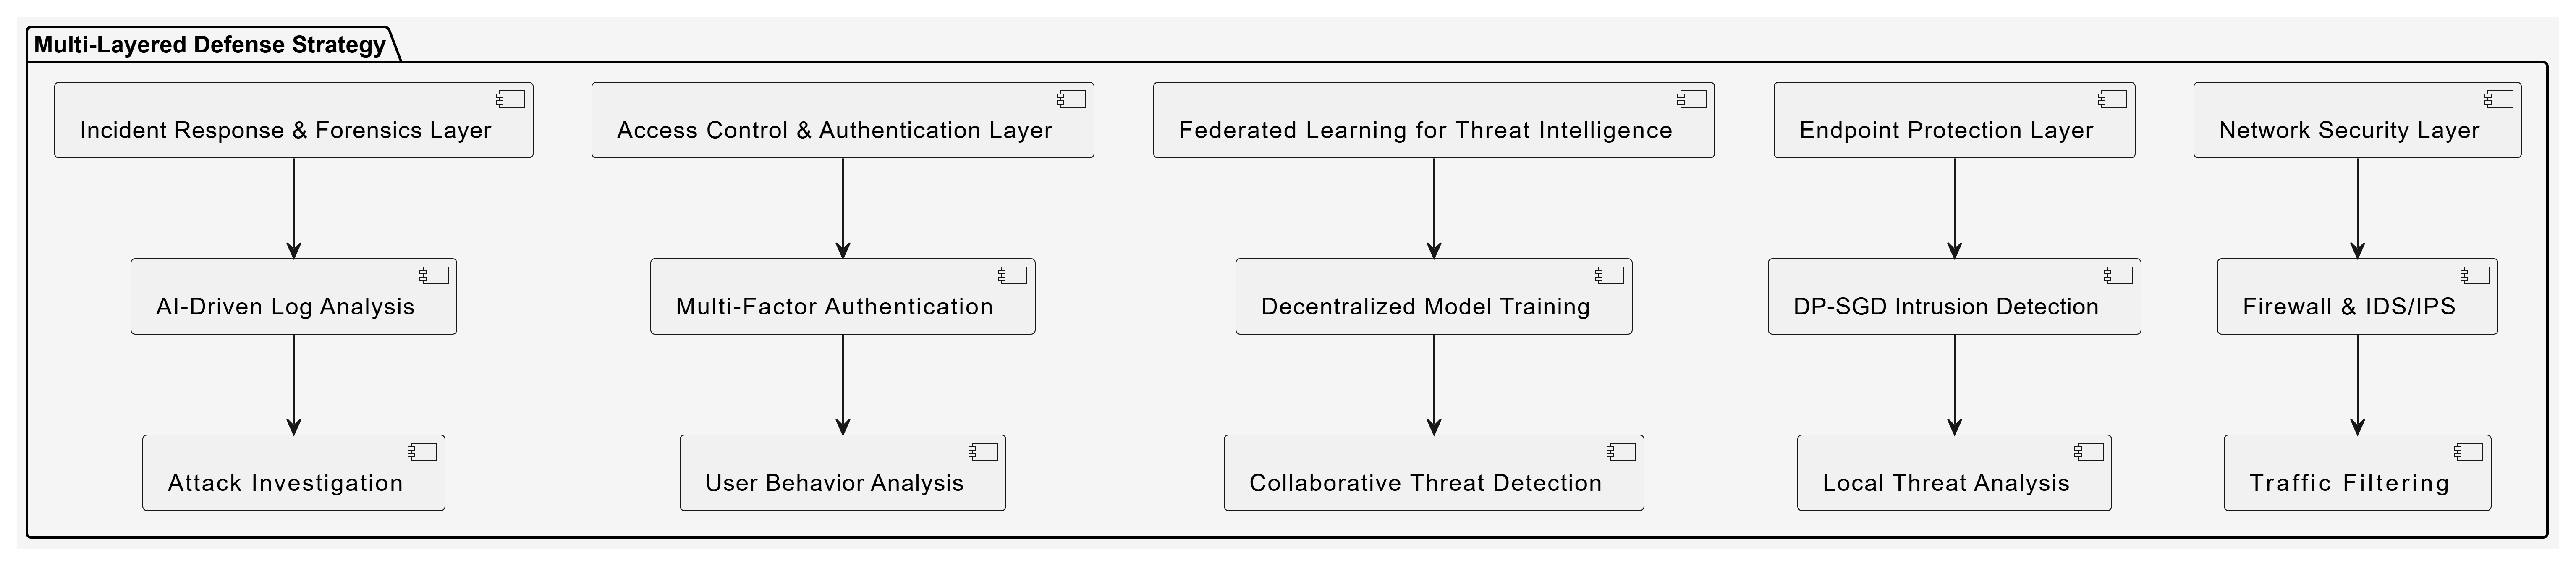

Each layer contributes to the overall security posture:

1. **Network Security Layer:** Implements firewalls and IDS/IPS to block known threats before reaching endpoints.

2. **Endpoint Protection Layer:** Deploys DP-SGD models on endpoint security tools for real-time anomaly detection.

3. **Federated Learning for Threat Intelligence:** Shares model updates without exposing raw data, enhancing collaborative threat detection.

4. **Access Control & Authentication Layer:** Uses multi-factor authentication (MFA) and behavioral analysis to prevent unauthorized access.

5. **Incident Response & Forensics Layer:** Employs AI-driven analytics for forensic analysis and proactive defense strategies.